### Rips and alpha complexes from matrix of pairwise distances

In [30]:
import numpy as np
import pickle as pck
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gdt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import os

from multiplier import *

In [56]:
# Define the paths to the files
path_file = "./ECG5000/"
train_file = "ECG5000_TRAIN.tsv"
test_file = "ECG5000_TEST.tsv"
labels_file = "labels.txt"

# Load the training set, test set, and labels file
train_data = pd.read_csv(path_file + train_file, sep="\t", header=None)
test_data = pd.read_csv(path_file + test_file, sep="\t", header=None)

corr_list = []

train_corr = train_data.corr()
test_corr = test_data.corr()
corr_list.append(train_corr)
corr_list.append(test_corr)

[          0         1         2         3         4         5         6     
0    1.000000  0.056507  0.336522  0.501615  0.567879  0.571526  0.424518  \
1    0.056507  1.000000  0.812696  0.547811  0.373893  0.159614 -0.039032   
2    0.336522  0.812696  1.000000  0.892506  0.743207  0.511709  0.177944   
3    0.501615  0.547811  0.892506  1.000000  0.943843  0.785210  0.452656   
4    0.567879  0.373893  0.743207  0.943843  1.000000  0.923861  0.650401   
..        ...       ...       ...       ...       ...       ...       ...   
136 -0.601733 -0.005950 -0.334921 -0.583044 -0.680940 -0.701253 -0.537906   
137 -0.598891  0.007698 -0.321605 -0.569082 -0.667821 -0.695927 -0.547396   
138 -0.571552  0.003278 -0.331445 -0.568068 -0.659088 -0.677810 -0.538472   
139 -0.555931 -0.001789 -0.361621 -0.586967 -0.670984 -0.674432 -0.521701   
140 -0.214413  0.177292  0.058215 -0.089408 -0.203973 -0.307094 -0.369658   

          7         8         9    ...       131       132       133   
0 

In [57]:
dist_list = [1 - np.abs(c) for c in corr_list]

D = dist_list[0]
D.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,0.000000,0.943493,0.663478,0.498385,0.432121,0.428474,0.575482,0.934709,0.803339,0.743045,...,0.556513,0.472588,0.424834,0.409874,0.400436,0.398267,0.401109,0.428448,0.444069,0.785587
1,0.943493,0.000000,0.187304,0.452189,0.626107,0.840386,0.960968,0.872368,0.878200,0.760209,...,0.687738,0.757978,0.846778,0.900473,0.944858,0.994050,0.992302,0.996722,0.998211,0.822708
2,0.663478,0.187304,0.000000,0.107494,0.256793,0.488291,0.822056,0.843070,0.727698,0.569512,...,0.450999,0.468076,0.531946,0.568491,0.607712,0.665079,0.678395,0.668555,0.638379,0.941785
3,0.498385,0.452189,0.107494,0.000000,0.056157,0.214790,0.547344,0.998387,0.762424,0.576811,...,0.345378,0.319391,0.343337,0.351779,0.376042,0.416956,0.430918,0.431932,0.413033,0.910592
4,0.432121,0.626107,0.256793,0.056157,0.000000,0.076139,0.349599,0.826093,0.857383,0.658377,...,0.334653,0.287206,0.283303,0.280132,0.292229,0.319060,0.332179,0.340912,0.329016,0.796027


In [63]:

skeleton = gd.RipsComplex(
    distance_matrix = D.values, 
    max_edge_length = 0.8
) 


Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension = 2)
Rips_simplex_tree.dimension()
Rips_simplex_tree.num_vertices()
Rips_simplex_tree.num_simplices()

rips_filtration = Rips_simplex_tree.get_filtration()
rips_list = list(rips_filtration)
len(rips_list)


for splx in rips_list[0:400] :
    print(splx)

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([16], 0.0)
([17], 0.0)
([18], 0.0)
([19], 0.0)
([20], 0.0)
([21], 0.0)
([22], 0.0)
([23], 0.0)
([24], 0.0)
([25], 0.0)
([26], 0.0)
([27], 0.0)
([28], 0.0)
([29], 0.0)
([30], 0.0)
([31], 0.0)
([32], 0.0)
([33], 0.0)
([34], 0.0)
([35], 0.0)
([36], 0.0)
([37], 0.0)
([38], 0.0)
([39], 0.0)
([40], 0.0)
([41], 0.0)
([42], 0.0)
([43], 0.0)
([44], 0.0)
([45], 0.0)
([46], 0.0)
([47], 0.0)
([48], 0.0)
([49], 0.0)
([50], 0.0)
([51], 0.0)
([52], 0.0)
([53], 0.0)
([54], 0.0)
([55], 0.0)
([56], 0.0)
([57], 0.0)
([58], 0.0)
([59], 0.0)
([60], 0.0)
([61], 0.0)
([62], 0.0)
([63], 0.0)
([64], 0.0)
([65], 0.0)
([66], 0.0)
([67], 0.0)
([68], 0.0)
([69], 0.0)
([70], 0.0)
([71], 0.0)
([72], 0.0)
([73], 0.0)
([74], 0.0)
([75], 0.0)
([76], 0.0)
([77], 0.0)
([78], 0.0)
([79], 0.0)
([80], 0.0)
([81], 0.0)
([82], 0.0)
([83], 0.0)
([

In [64]:
from sklearn.manifold import MDS
 
embedding = MDS(n_components = 3, dissimilarity = 'precomputed')
X_transformed = embedding.fit_transform(D)
X_transformed.shape

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(141, 3)

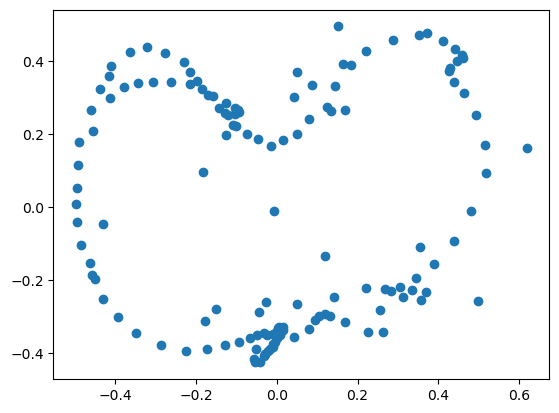

In [65]:
fig = plt.figure()
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], label = 'MDS');

In [68]:
alpha_complex = gd.AlphaComplex(points = X_transformed)

st_alpha = alpha_complex.create_simplex_tree()

st_alpha.dimension()

print(st_alpha.num_vertices())

print(st_alpha.num_simplices())

141
3575


### Persistent homology and persistence diagrams

In [72]:
D0 = dist_list[0]


skeleton_0 = gd.RipsComplex(
    distance_matrix = D0.values, 
    max_edge_length = 0.8
) 

Rips_simplex_tree_0 = skeleton_0.create_simplex_tree(max_dimension = 2)


BarCodes_Rips_0 = Rips_simplex_tree_0.persistence()


for i in range(20):
    print(BarCodes_Rips_0[i])


Rips_simplex_tree_0.persistence_intervals_in_dimension(0)

(1, (0.14436591403726062, 0.6659021746061609))
(1, (0.25037552414462805, 0.6051797326969386))
(1, (0.28013206642756616, 0.6126665908024387))
(1, (0.4160548351530031, 0.6391384451015605))
(1, (0.3514937971117075, 0.570032721717591))
(1, (0.3981219612318505, 0.5579141212556262))
(1, (0.41547483003501806, 0.49784431281637753))
(1, (0.4684785419056172, 0.5498409842035608))
(1, (0.4350465845923803, 0.49194558162017255))
(1, (0.31114925887809053, 0.3476656320152749))
(1, (0.4363691255923239, 0.46995592780456996))
(1, (0.4784561643871489, 0.5033954889378928))
(1, (0.4509266817317259, 0.46356537243535556))
(1, (0.3982674154086794, 0.4098743966716093))
(1, (0.40196371148426113, 0.4101937760541854))
(0, (0.0, inf))
(0, (0.0, 0.3655682190442566))
(0, (0.0, 0.29854747237276036))
(0, (0.0, 0.21521975584810737))
(0, (0.0, 0.1963172864655246))


array([[0.        , 0.00930049],
       [0.        , 0.00973907],
       [0.        , 0.01063658],
       [0.        , 0.01079191],
       [0.        , 0.01079855],
       [0.        , 0.01085719],
       [0.        , 0.01092587],
       [0.        , 0.01231744],
       [0.        , 0.01233262],
       [0.        , 0.01238365],
       [0.        , 0.01242509],
       [0.        , 0.01256132],
       [0.        , 0.01293152],
       [0.        , 0.01371509],
       [0.        , 0.01376757],
       [0.        , 0.01395129],
       [0.        , 0.01418864],
       [0.        , 0.0143271 ],
       [0.        , 0.0148991 ],
       [0.        , 0.01490754],
       [0.        , 0.01498753],
       [0.        , 0.01515925],
       [0.        , 0.01610204],
       [0.        , 0.01612793],
       [0.        , 0.01612829],
       [0.        , 0.01679704],
       [0.        , 0.01795747],
       [0.        , 0.01797054],
       [0.        , 0.01833598],
       [0.        , 0.01836297],
       [0.

/opt/anaconda3/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


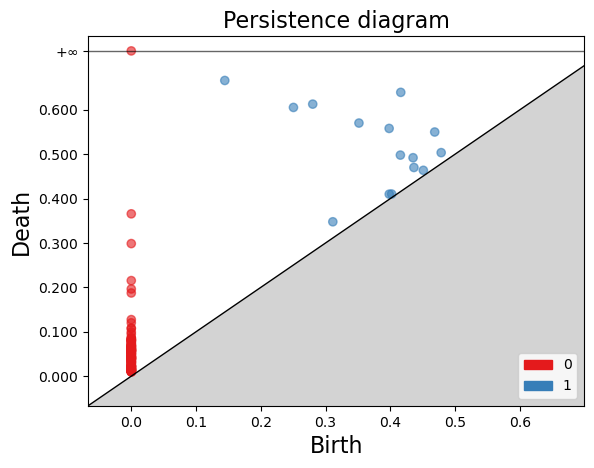

In [73]:
gd.plot_persistence_diagram(BarCodes_Rips_0);